COMP30850 - Networking Assignment 2
Student Number - 17328666

The goal of this assignment is to create and characterise a range of different network
representations, created from pre-collected Twitter data for a specific Twitter List of
user accounts that relates to a specific topic. From the datasets provided for this project,  I haved selected the tennis dataset as my topic to analysis. For this project to run, you should run it from inside the tennis folder. You can download this tennis folder at http://mlg.ucd.ie/modules/COMP30850/lists/ 

In [1]:
import networkx as nx
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Network Creation
In this section all the required networks are built starting with tweets about tennis data. First, the followers data is loaded into a dataframe, this is then used to construct the corresponding unweighted directed network. The date attribute is attached to the edges: this will help when creating the dynamic network later on in the project.

In [3]:
# read follower relation data from inside the tennis folder
df = pd.read_csv('./followers.csv', 
                 sep='\t')
# build follower network
g_follow = nx.from_pandas_edgelist(df, source='source', target='target', create_using=nx.DiGraph, edge_attr='date')

A reply network will now be created. Firstly the tweet data is loaded into memory. To use a pandas dataframe would not be efficient, and may create issues because tweet data is usually represented in the form of nested dictionaries (while with pandas only the outer layer can be indexed). Thus, the best approach is to load data into a list of (nested) dictionaries. 

In [5]:
with open('./tweets.jsonl') as f:
    tweet_data = [json.loads(line.strip()) for line in f]

In [6]:
print('What we know about each tweet:', list(tweet_data[0].keys())) #Tweet data info below

What we know about each tweet: ['created_at', 'id', 'id_str', 'full_text', 'truncated', 'display_text_range', 'entities', 'extended_entities', 'source', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place', 'contributors', 'is_quote_status', 'retweet_count', 'favorite_count', 'favorited', 'retweeted', 'possibly_sensitive', 'lang']


In [7]:
print('What we know about each tweet author:', list(tweet_data[0]['user'].keys())) # 

What we know about each tweet author: ['id', 'id_str', 'name', 'screen_name', 'location', 'description', 'url', 'entities', 'protected', 'followers_count', 'friends_count', 'listed_count', 'created_at', 'favourites_count', 'utc_offset', 'time_zone', 'geo_enabled', 'verified', 'statuses_count', 'lang', 'contributors_enabled', 'is_translator', 'is_translation_enabled', 'profile_background_color', 'profile_background_image_url', 'profile_background_image_url_https', 'profile_background_tile', 'profile_image_url', 'profile_image_url_https', 'profile_banner_url', 'profile_link_color', 'profile_sidebar_border_color', 'profile_sidebar_fill_color', 'profile_text_color', 'profile_use_background_image', 'has_extended_profile', 'default_profile', 'default_profile_image', 'following', 'follow_request_sent', 'notifications', 'translator_type', 'withheld_in_countries']


Note how the 'user' data is a dictionary nested into the main tweet data dictionary.


Now  the directed weighted reply network can be built. For each source-target pair, we check for its existence in the network. If it is found, the weight is incremented; otherwise the edge is added with weight 1.

In [8]:
g_reply = nx.DiGraph()
for tweet in tweet_data:
    source = tweet['user']['screen_name']
    target = tweet['in_reply_to_screen_name']
    if target:
        if g_reply.has_edge(source, target):
            g_reply[source][target]['weight'] += 1
        else:
            g_reply.add_edge(source, target, weight=1)

Similarly, a mention network is a directed weighted network. Same rationale as before, but here each tweet can contain multiple mentions, so we have to loop through each of them.

In [9]:
g_mention = nx.DiGraph()
for tweet in tweet_data:
    source = tweet['user']['screen_name']
    targets = tweet['entities']['user_mentions']
    if targets:
        for target in targets:
            target = target['screen_name']
            if g_mention.has_edge(source, target):
                g_mention[source][target]['weight'] += 1
            else:
                g_mention.add_edge(source, target, weight=1)


The user-hashtag network is a bipartite weighted network that relates users to the hashtags they use. Since hashtag on twitter are not case sensitive, they are transformed into lowercase to group the same hashtags with different capitalization (e.g., we want #tennis, #TENNIS, and #Tennis to be identified by the same node). Also, every username is capitalized  as some usernames might appear in the hashtags set. Doing so, we avoid that a node is considered both as type 1 and type 0.

In [10]:
g_userhash = nx.Graph()
for tweet in tweet_data:
    source = tweet['user']['screen_name'].upper()
    targets = tweet['entities']['hashtags']
    
    # check if user is in network, if not, add
    if not g_userhash.has_node(source):
        g_userhash.add_node(source, bipartite=0)
    if targets:
        for target in targets:
            target = target['text'].lower() # to lowercase
            if g_userhash.has_edge(source, target):
                g_userhash[source][target]['weight'] += 1
            else:
                # check if hashtag is in network, if not, add
                if not g_userhash.has_node(target):
                    g_userhash.add_node(target, bipartite=1)
                g_userhash.add_edge(source, target, weight=1)

The hashtag-hashtag network is an undirected weighted network that links two hashtags if they are used in the same tweet. Only hashtags used in pairs are included (i.e., if only one hashtag is used, it is not included). Since tweets can have more than two hashtags, I used a built-in python function that returns all pairwise combinations of the hashtags in a tweet. 

In [11]:
from itertools import combinations

g_hashhash = nx.Graph()
for tweet in tweet_data:
    hashtags = tweet['entities']['hashtags']
    
    if len(hashtags) >= 2: 
        hashtags = [hashtag['text'].lower() for hashtag in hashtags]
        for source, target in combinations(hashtags, 2):
            if g_hashhash.has_edge(source, target):
                g_hashhash[source][target]['weight'] += 1
            else:
                g_hashhash.add_edge(source, target, weight=1)

Lastly, three directed unweighted networks are built (i.e. a dynamic network). This representation is cumulative. This means that if user A starts to follow B in 2020, it will still follow them in 2021 and 2022 (i.e., edges in a previous timestamp are also present in future timestamps). This models the real behavior of twitter users.

In [12]:
g_2020 = nx.DiGraph()
g_2021 = nx.DiGraph()
g_2022 = nx.DiGraph()
for source, target, data in g_follow.edges(data=True):
    if data['date'].startswith('2020'):
        g_2020.add_edge(source, target)
        g_2021.add_edge(source, target)
        g_2022.add_edge(source, target)
    elif data['date'].startswith('2021'):
        g_2021.add_edge(source, target)
        g_2022.add_edge(source, target)
    else:
        g_2022.add_edge(source, target)


### 1.1 Helper functions
Before analyzing the data, some functions are declared to avoid code duplication

In [13]:
def network_statistics(g):
    
    print(f'Number of nodes: {g.number_of_nodes()}')
    print(f'Number of edges: {g.number_of_edges()}')
    print(f'Density: {round(nx.density(g), 3)}')
    print(f'Average Clustering Coefficient: {round(nx.average_clustering(g), 3)}')
    if g.is_directed():
        print(f'Strongly connected components: {nx.number_strongly_connected_components(g)}')
        print(f'Weakly connected components: {nx.number_weakly_connected_components(g)}')
        lcc = max(nx.strongly_connected_components(g), key=len)
        print(f'Size largest strongly connected component: {len(lcc)}')
        
    else:
        print(f'Connected components: {nx.number_connected_components(g)}')
        lcc = max(nx.connected_components(g), key=len)
        print(f'Size largest connected component: {len(lcc)}')
    print(f'Diameter (largest component): {nx.diameter(nx.subgraph(g, lcc))}')
        
    
    
def plot_weights_dist(g, bins=50):
    
    weights = nx.get_edge_attributes(g, 'weight')
    plt.title('Weights distribution')
    sns.histplot(data=weights.values(), bins=bins, label='weight')
    plt.show()

def plot_degree_by_node(g, limit_to=32):  
    degs = {k: v for k, v in sorted(dict(g.in_degree()).items(), key=lambda x: -x[-1])[:limit_to]}
    plt.figure(figsize=(15, 8))
    plt.title('In degree by node')
    sns.barplot(x=list(degs.keys()), y =list(degs.values()), color='blue')
    plt.xlabel('Number of incoming links', fontsize=10)
    plt.xticks(rotation = 90) 
    plt.show()

def plot_degree_dist(g):
    """
    plots node degree distribution
    """
    
    in_degree = list(dict(g.in_degree()).values())
    out_degree =list(dict(g.out_degree()).values())
    fig, axs = plt.subplots(ncols=2, figsize=(16, 8)) 
    sns.histplot(data=in_degree, color='blue',ax=axs[0]) 
    sns.histplot(data=out_degree, color='red', ax=axs[1])
    axs[0].set_xlabel('In Degree')
    axs[1].set_xlabel('Out Degree')
    axs[0].set_ylabel('Frequency')
    plt.show()
    
def get_top(measure, top=10):
    """
    returns the top ten elements according to the measures param
    """
    ranks = [(k, v) for k, v in sorted(measure.items(), key=lambda item: -item[1])]
    return ranks[:top]


## 2. Follower network
I will analyze the follower network first. It is important to distinguish between in-degree (number of accounts that follow a node in the network) and out degree (number of accounts that are followed by a node in the network). Firstly, I will examine the general network statistics.plt.figure(figsize=(15, 8))

In [14]:
network_statistics(g_follow)

Number of nodes: 32
Number of edges: 544
Density: 0.548
Average Clustering Coefficient: 0.664
Strongly connected components: 3
Weakly connected components: 1
Size largest strongly connected component: 30
Diameter (largest component): 4


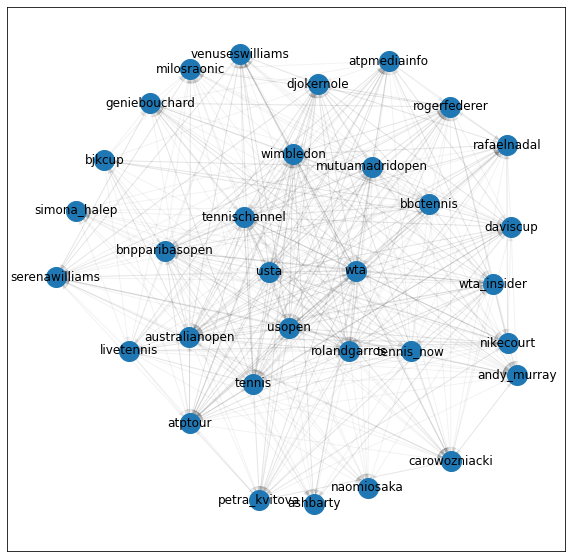

In [15]:
pos = nx.spring_layout(g_follow, k=3)
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(g_follow, pos=pos, node_size=400)
nx.draw_networkx_edges(g_follow, pos=pos, alpha=0.05)
nx.draw_networkx_labels(g_follow, pos=pos)
plt.show()

Despite having only 32 nodes, this network is tightly connected and dense. A density of 0.5 is uncommon for real networks, which are generally sparse. This high network density is probably due to the fact that this is a sample of 32 popular accounts in the tennis domain, so they probably know and follow each other on twitter.
This is exemplified by the fact that if we ignore the edge direction, the network is fully connected (weakly connected). The diameter is also four, meaning that a node is at most 3 nodes away to every other node in the network.

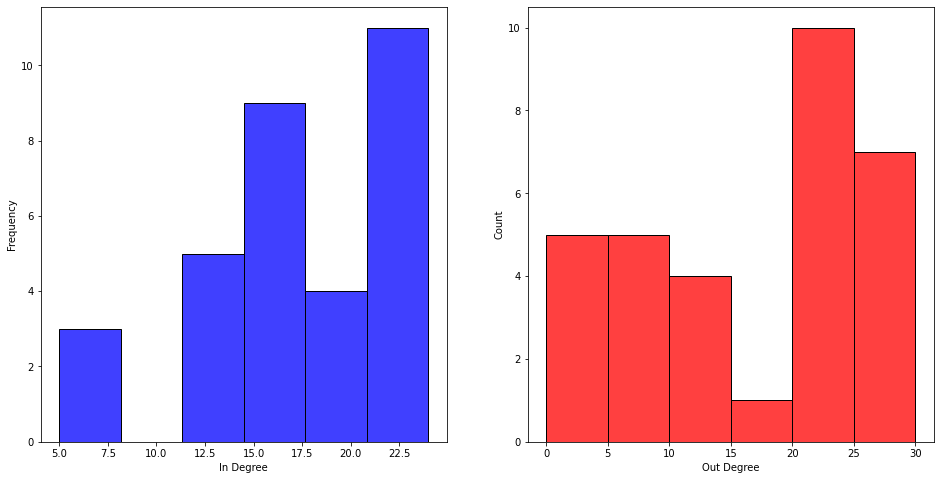

In [16]:
plot_degree_dist(g_follow)

Here we see that nodes have generally high in and out degrees (i.e., high with respect to the distribution, which is skewed to the right). This confirms the fact that the network is tightly connected.

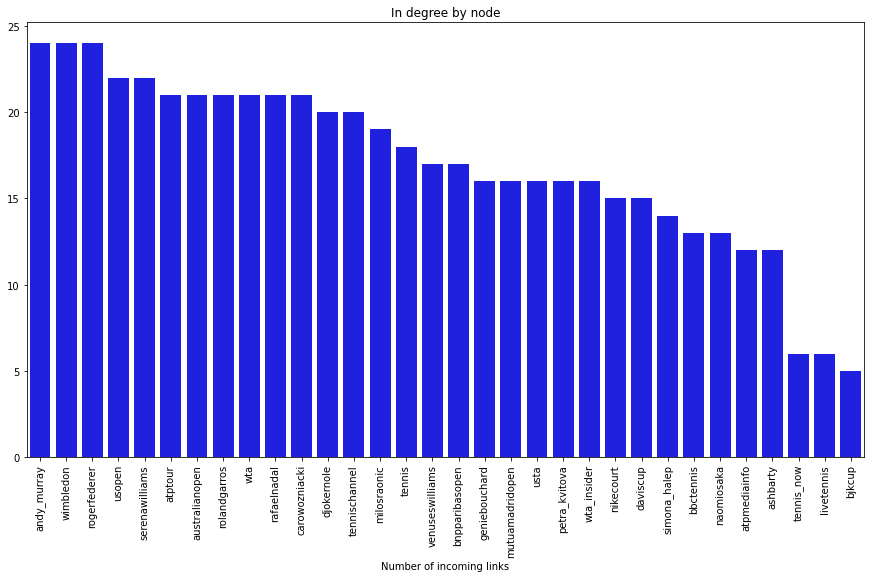

In [17]:
plot_degree_by_node(g_follow)

Among the most followed we can see Murray, Williams and Feder, renowned tennis champions. Also, official accounts of UK and USA based international tennis tournaments.

## 3. Reply network

In [18]:
network_statistics(g_reply)

Number of nodes: 907
Number of edges: 1148
Density: 0.001
Average Clustering Coefficient: 0.023
Strongly connected components: 886
Weakly connected components: 3
Size largest strongly connected component: 22
Diameter (largest component): 5


This network is considerably sparser with respect to the previous network. This occured because it additionally contains all the people those VIP accounts replied to, this includes aother VIPs in and average user accounts. This also reflects in the networks more fragmented strucure. Note that the diameter is 5, which is very low – but that's because we are only considering the largest strongly connected component of size 22.

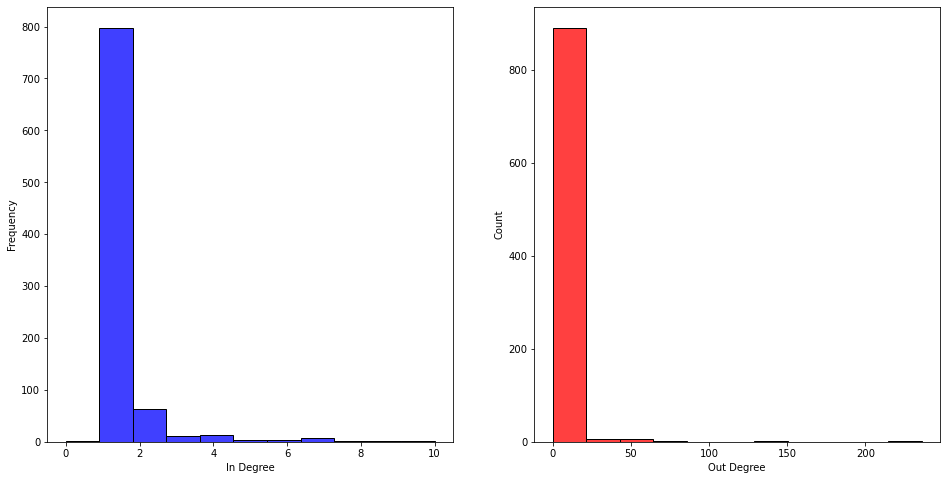

In [19]:
plot_degree_dist(g_reply)

Of course, here most nodes are low in degree (since our tennis VIPs probably replied to every one very few times), and also low out degree, because the "others" replies are not included in the data. Note that some of our VIPs were never reached by incoming links (left plot's "0" bin is small).

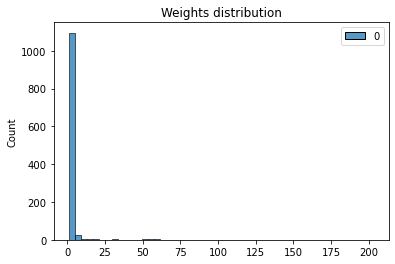

In [20]:
plot_weights_dist(g_reply)

We can see that most edges have low weight (i.e. one or few more replies). Still, some interactions happened 50 to 200 times. I will now list which pairs of nodes replied more frequently:

In [21]:
weights = nx.get_edge_attributes(g_reply, 'weight')
for edge, w in get_top(weights, top=15):
    print(edge, w)

('BJKCup', 'BJKCup') 203
('Wimbledon', 'Wimbledon') 173
('DavisCup', 'DavisCup') 149
('AustralianOpen', 'AustralianOpen') 97
('livetennis', 'livetennis') 90
('rolandgarros', 'rolandgarros') 85
('DjokerNole', 'DjokerNole') 60
('RafaelNadal', 'RafaelNadal') 58
('WTA', 'WTA') 56
('atptour', 'atptour') 56
('usopen', 'usopen') 53
('MutuaMadridOpen', 'MutuaMadridOpen') 53
('TennisChannel', 'TennisChannel') 36
('Simona_Halep', 'darren_cahill') 32
('WTA_insider', 'WTA_insider') 31


Interestingly, the most frequent edges are self-loops. This is the result of a very common strategy on twitter. Since the platform limits the users' tweets to very few characters, those wanting to write longer posts often write more tweets as self-replies.

## 4. Mention Network

In [22]:
network_statistics(g_mention)

Number of nodes: 3318
Number of edges: 5921
Density: 0.001
Average Clustering Coefficient: 0.12
Strongly connected components: 3289
Weakly connected components: 1
Size largest strongly connected component: 30
Diameter (largest component): 4


The mention network is even larger and sparser. This can be seen as a superset (i.e., a container) of the reply network: when you reply to someone on twitter you mention them by default, plus any additional mentions that you include in the tweet. From this it is clear that network fragmentation and low density are key characterizing factors.

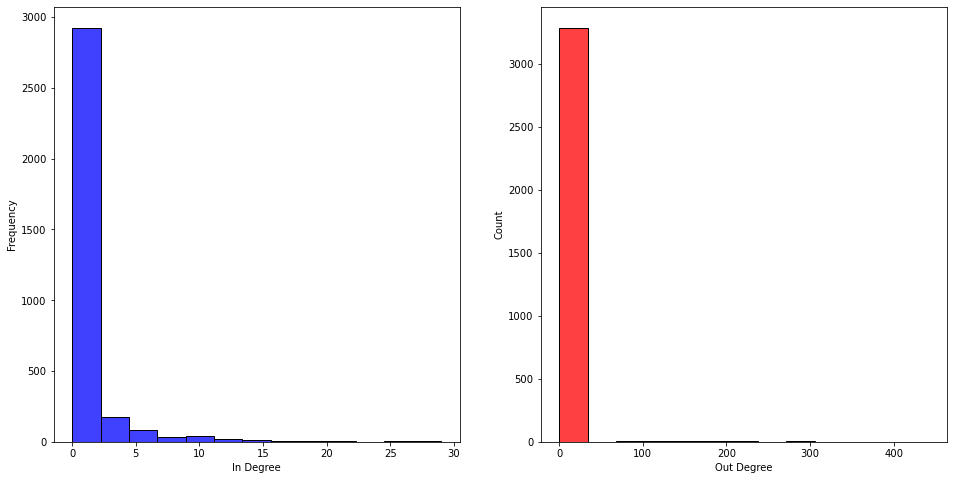

In [23]:
plot_degree_dist(g_mention)

As in most real networks, most of the nodes have low degrees, meaning they have mentioned or been mentioned few times. Note that the out degree's range is higher than the in degree range.

In [24]:
print('In degrees:')
for node, d in get_top(dict(g_mention.in_degree()), top=5):
    print(node, d)
print('\nOut degrees:')
for node, d in get_top(dict(g_mention.out_degree()), top=5):
    print(node, d)

In degrees:
RafaelNadal 29
serenawilliams 27
AustralianOpen 27
usopen 27
WTA 25

Out degrees:
andy_murray 441
Venuseswilliams 325
serenawilliams 299
milosraonic 294
geniebouchard 283


Among the most mentioned users are Nadal and Willams, as well as offical accounts of renowned tennis tournaments.
For users the tennis player Andy Murray seems to have received the most mentions, followed by the Williams sisters, Venus and Serena.

In [25]:
weights = nx.get_edge_attributes(g_mention, 'weight')
for edge, w in get_top(weights):
    print(edge, w)

('bbctennis', 'BBCSport') 352
('milosraonic', 'milosraonic') 292
('usta', 'usopen') 247
('atptour', 'RolexPMasters') 189
('Venuseswilliams', 'EleVenbyVenus') 183
('Venuseswilliams', 'Venuseswilliams') 168
('MutuaMadridOpen', 'atptour') 146
('MutuaMadridOpen', 'ATPTour_ES') 140
('ATPMediaInfo', 'RafaelNadal') 136
('ATPMediaInfo', 'DjokerNole') 134


Here we can see some difference with respect to the interaction frequencies of the reply network. Although some self loops remain in the top 10 (e.g. Venuseswilliams), most are between media accounts (e.g. bbctennis and BBCsport) or between media accounts and players (e.g.,'ATPMediaInfo', 'RafaelNadal') 

## 5. User-Hashtag Network
Firstly, I will check if the data processing actually produced a bipartite graph:

In [26]:
from networkx.algorithms import bipartite
bipartite.is_bipartite(g_userhash)

True

It has, now I will print some statistics about the network

In [27]:
network_statistics(g_userhash)

Number of nodes: 2456
Number of edges: 3125
Density: 0.001
Average Clustering Coefficient: 0.0
Connected components: 1
Size largest connected component: 2456
Diameter (largest component): 6


Here, the statistics of the network do not tell us much, as nodes are different in nature.

In [28]:
bottom, top = bipartite.sets(g_userhash)

In [29]:
print(f'The network has {len(bottom)} users and {len(top)} hashtags')
print(f'Each user tweets {len(top)/len(bottom)} different hashtags on average')

The network has 32 users and 2424 hashtags
Each user tweets 75.75 different hashtags on average


In [30]:
weights = nx.get_edge_attributes(g_userhash, 'weight')
for edge, w in get_top(weights):
    print(edge, w)

('MUTUAMADRIDOPEN', 'mmopen') 776
('DAVISCUP', 'daviscup') 689
('wimbledon', 'WIMBLEDON') 688
('BNPPARIBASOPEN', 'indianwells') 669
('DAVISCUP', 'byrakuten') 634
('BJKCUP', 'bjkcupfinals') 594
('LIVETENNIS', 'usopen') 575
('AUSTRALIANOPEN', 'ausopen') 390
('WIMBLEDON', 'centrecourt100') 339
('ATPTOUR', 'nittoatpfinals') 315


Here we see that often official accounts use the same recurring hashtag, e.g. to advertise a tournament on twitter. For instance, the offical Madrid open account used hastag mmopen 776 times in their tweets, the offical Davis cup account used hashtag davis cup 689 times. I will now examine if other accounts tweeted theese hashtags as well.

In [31]:
list(g_userhash.neighbors('mmopen'))

['MUTUAMADRIDOPEN',
 'DJOKERNOLE',
 'ATPMEDIAINFO',
 'SIMONA_HALEP',
 'NAOMIOSAKA',
 'ASHBARTY',
 'GENIEBOUCHARD',
 'AUSTRALIANOPEN',
 'MILOSRAONIC']

In [32]:
list(g_userhash.neighbors('daviscup'))

['DAVISCUP',
 'BBCTENNIS',
 'RAFAELNADAL',
 'ANDY_MURRAY',
 'USTA',
 'MILOSRAONIC',
 'LIVETENNIS',
 'BJKCUP',
 'DJOKERNOLE']

Other accounts also tweeted about #mmopen and #daviscup, altough not many of them. Novak Djokovic was the only account to tweet both hashtags. 

## 6. Hashtag-Hashtag Network

In [33]:
network_statistics(g_hashhash)

Number of nodes: 1576
Number of edges: 2624
Density: 0.002
Average Clustering Coefficient: 0.462
Connected components: 254
Size largest connected component: 899
Diameter (largest component): 11


The hashtag-hashtag network is the first and only simple graph (i.e., no edge directedness, no bipartition) of this analysis. It is very sparse, but much clustered (0.46 avg cc). Still, it is fragmented in many connected components, with the largest containing more than half the nodes. With such a larger component the network is not very cohese, since the diameter of the largest component is longer than all the other networks. 

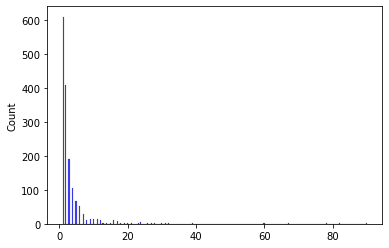

In [34]:
degree = list(dict(g_hashhash.degree()).values())
sns.histplot(data=degree, color='blue') 
plt.show()

Here we see that most hashtags appear in pairs with very few other hashtags.

In [35]:
for node, d in get_top(dict(g_hashhash.degree())):
    print(node, d)

ausopen 90
ad 82
tennis 78
usopen 67
wimbledon 60
atptour 39
grandslam 32
rolandgarros 32
vamos 32
djokovic 31


Among the most pairwise cited hashtags are general purpose tags like 'ad' (i.e., advertisement), 'tennis' and once again tags about tournaments and players. However, the degree does not tell us much about the hashtag frequency; instead, high degree here means that the hashtag appears with several different others.

In [36]:
weights = nx.get_edge_attributes(g_hashhash, 'weight')
for edge, w in get_top(weights):
    print(edge, w)

('daviscup', 'byrakuten') 636
('federer', 'federer') 465
('wimbledon', 'centrecourt100') 334
('ausopen', 'ao2022') 226
('bjkcupfinals', 'worldcupoftennis') 78
('usopen', 'ad') 52
('ausopen', 'aotennis') 44
('bbctennis', 'ausopen') 42
('ausopen', 'aoplayers') 34
('aotennis', 'aoplayers') 34


The most frequent hashtag pair in the dataset is ('daviscup', 'byrakuten'), which is a popular tourneament sponsored by Japanese tech giant Rakuten. Also, many tweets contain hashtags about Roger Federer, perhaps with different capitalization (but since we normalized *after* extracting the couples, these hashtags appear as separated). Other frequent pairs are related to the australian open ('ausopen', 'ao2022') ('ausopen', 'aotennis')
('bbctennis', 'ausopen') 
('ausopen', 'aoplayers')
('aotennis', 'aoplayers')

By leveraging the weighted degree centrality we can see which hashtags were the most frequent overall

In [37]:
for node, d in get_top(dict(g_hashhash.degree(weight='weight'))):
    print(node, d)

federer 957
daviscup 690
byrakuten 652
ausopen 533
wimbledon 459
ao2022 343
centrecourt100 334
ad 211
usopen 194
aotennis 121


Federer seems to be the most frequent overall. It's interesting because the unweighted degree centrality did not capture federer among the top hashtags – but we saw it was frequent in the pairwise frequencies above. Still, degrees do not capture the networked nature of information flow. Thus, we leverage betweenness centrality. We use the standard (unweighted) betweenness centrality here, as the weighted version treats weights as distances (so, in our case, high frequency pairs would be considered distant instead of close)

In [38]:
for node, d in get_top(dict(nx.betweenness_centrality(g_hashhash))):
    print(node, round(d, 4))

usopen 0.0865
ausopen 0.0824
tennis 0.0811
ad 0.0645
wimbledon 0.0562
nittoatpfinals 0.0279
nolefam 0.0269
teammilos 0.0258
vamos 0.0235
wta 0.0204


Despite being the most frequent, the #federer hashtag does not do a very good job with respect to information flow. Instead, hashtags concerning tennis opens, advertisements and tennis in general are more likely to spread information.

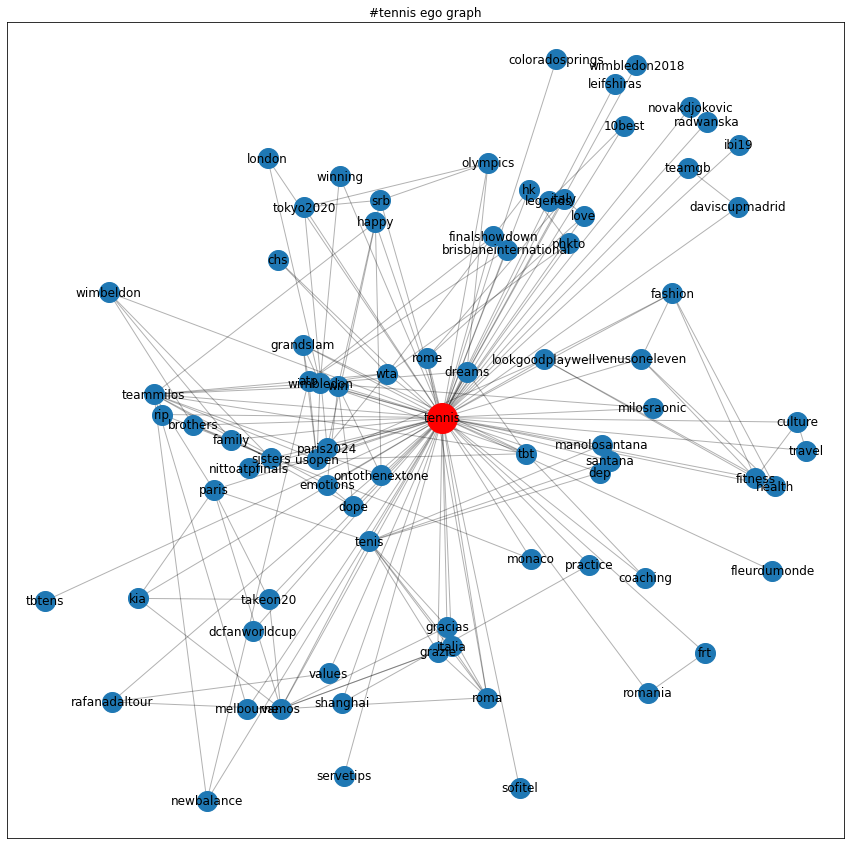

In [39]:
ego = 'tennis'
pos = nx.spring_layout(g_hashhash, k=0.2)
plt.figure(figsize=(15,15))
plt.title('#tennis ego graph', fontsize=12)
eg = nx.ego_graph(g_hashhash, ego)

# draw network
nx.draw_networkx_nodes(eg, pos=pos, node_size=400)
nx.draw_networkx_edges(eg, pos=pos, alpha=0.3)

# draw the ego in a different colour with larger node size
nx.draw_networkx_nodes(eg, pos=pos, nodelist=[ego], node_size=900, 
                       node_color='red')


nx.draw_networkx_labels(eg, pos=pos)
plt.show()

With this ego graph we can se that the reason for the popularity of #tennis is that, since it is very general, is paired with a lot of different keyword, ranging from tennis players, to tournaments, venues (e.g., 'rome'), to concepts like 'practice' and 'values'.

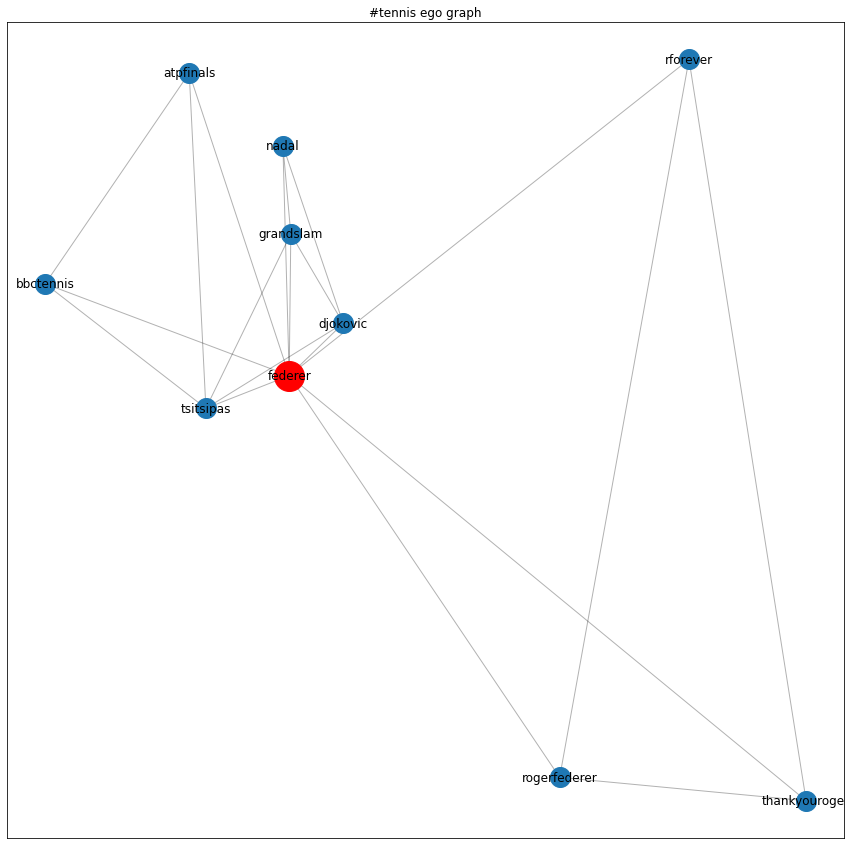

In [40]:
ego = 'federer'
pos = nx.spring_layout(g_hashhash, k=0.2)
plt.figure(figsize=(15,15))
plt.title('#tennis ego graph', fontsize=12)
eg = nx.ego_graph(g_hashhash, ego)

# draw network
nx.draw_networkx_nodes(eg, pos=pos, node_size=400)
nx.draw_networkx_edges(eg, pos=pos, alpha=0.3)

# draw the ego in a different colour with larger node size
nx.draw_networkx_nodes(eg, pos=pos, nodelist=[ego], node_size=900, 
                       node_color='red')


nx.draw_networkx_labels(eg, pos=pos)
plt.show()

By looking at the ego graph for #federer, we see that it is mostly linked to other hashtags referring to him, like #thanksroger, or #rogerfederer. Nadal and Djokovic can be seen as well which is unsuprising given that the trio are fierce rivals of one another and considered together to be the three best players of modern mens tennis.

## 7. Dynamic Network

Here I haved enclosed the snapshots in a list for ease of parsing.

In [41]:
snapshots = [g_2020, g_2021, g_2022]
for i, snap in enumerate(snapshots):
    print(f'Stats in year 202{i}')
    network_statistics(snap)
    print()

Stats in year 2020
Number of nodes: 32
Number of edges: 254
Density: 0.256
Average Clustering Coefficient: 0.34
Strongly connected components: 4
Weakly connected components: 1
Size largest strongly connected component: 29
Diameter (largest component): 4

Stats in year 2021
Number of nodes: 32
Number of edges: 415
Density: 0.418
Average Clustering Coefficient: 0.53
Strongly connected components: 3
Weakly connected components: 1
Size largest strongly connected component: 30
Diameter (largest component): 4

Stats in year 2022
Number of nodes: 32
Number of edges: 544
Density: 0.548
Average Clustering Coefficient: 0.664
Strongly connected components: 3
Weakly connected components: 1
Size largest strongly connected component: 30
Diameter (largest component): 4



Over the course of the three years, the following topological changes can be noted:
- The following relations almost doubled in 2021 w.r.t. the previous year; they further increased by around 150 in 2022
- The density has always been generally high (e.g. with respect to the other networks analyzed here), and it more than doubled in three years. 
- The same can be said for the average clustering coefficient, which increased from .34 to .66
- By observing edge directions, we find 4 connected components, which become 2 in 2022, likely due to the increased connectivity or because an isolated node joined (i.e., connected with) the rest of the network. The size of the largest component increases by 1 in 2021


Nodes and diameter remain the same.

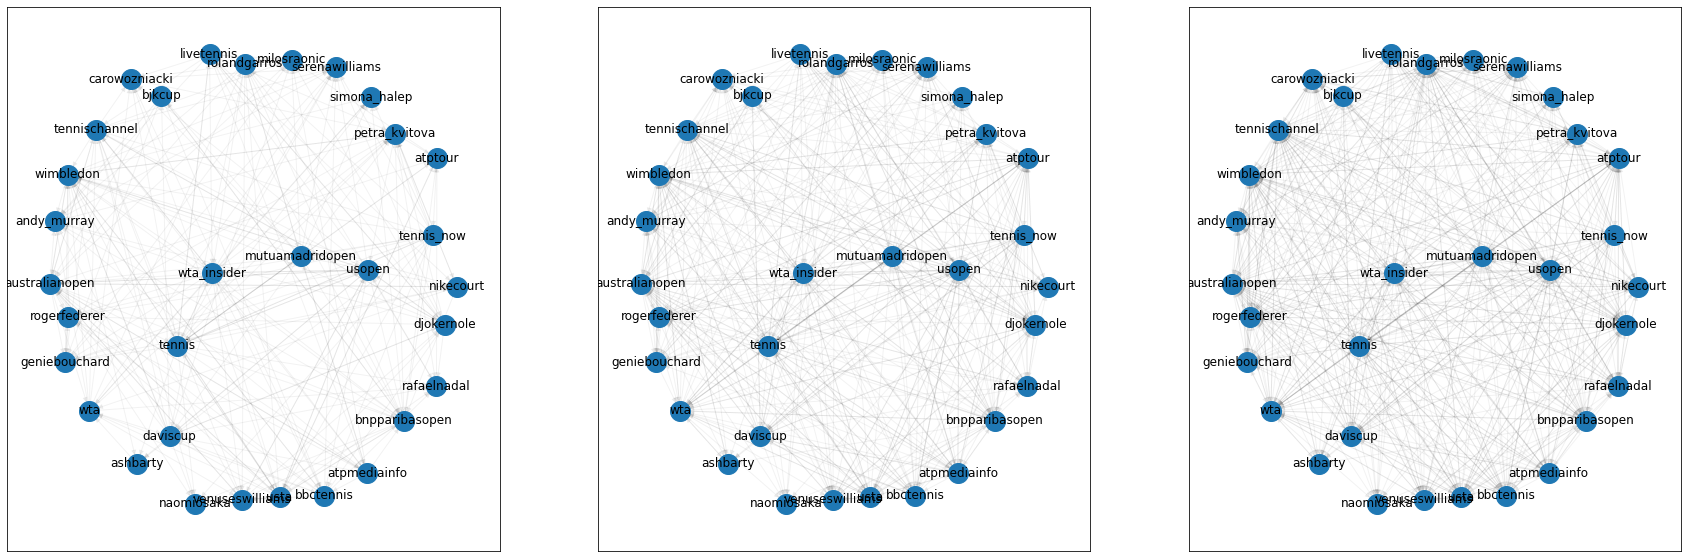

In [42]:
pos = nx.spring_layout(snapshots[0], k=3)
fig, axs = plt.subplots(figsize=(30,10), ncols=3)
for i in range(3):
    nx.draw_networkx_nodes(snapshots[i], pos=pos, node_size=400, ax=axs[i])
    nx.draw_networkx_edges(snapshots[i], pos=pos, alpha=0.05, ax=axs[i])
    nx.draw_networkx_labels(snapshots[i], pos=pos, ax=axs[i])

plt.show()

From the plots, the increase in connectedness is increasing noticeably year after year. 

I will now examine how the follower network around Serena Williams changed across the last three years. I accomplished this by employing an ego-centric analysis.

In [43]:
pos = nx.spring_layout(snapshots[0], k=3)

for i in range(3):
    nx.draw_networkx_nodes(snapshots[i], pos=pos, node_size=400, ax=axs[i])
    nx.draw_networkx_edges(snapshots[i], pos=pos, alpha=0.05, ax=axs[i])
    nx.draw_networkx_labels(snapshots[i], pos=pos, ax=axs[i])

plt.show()

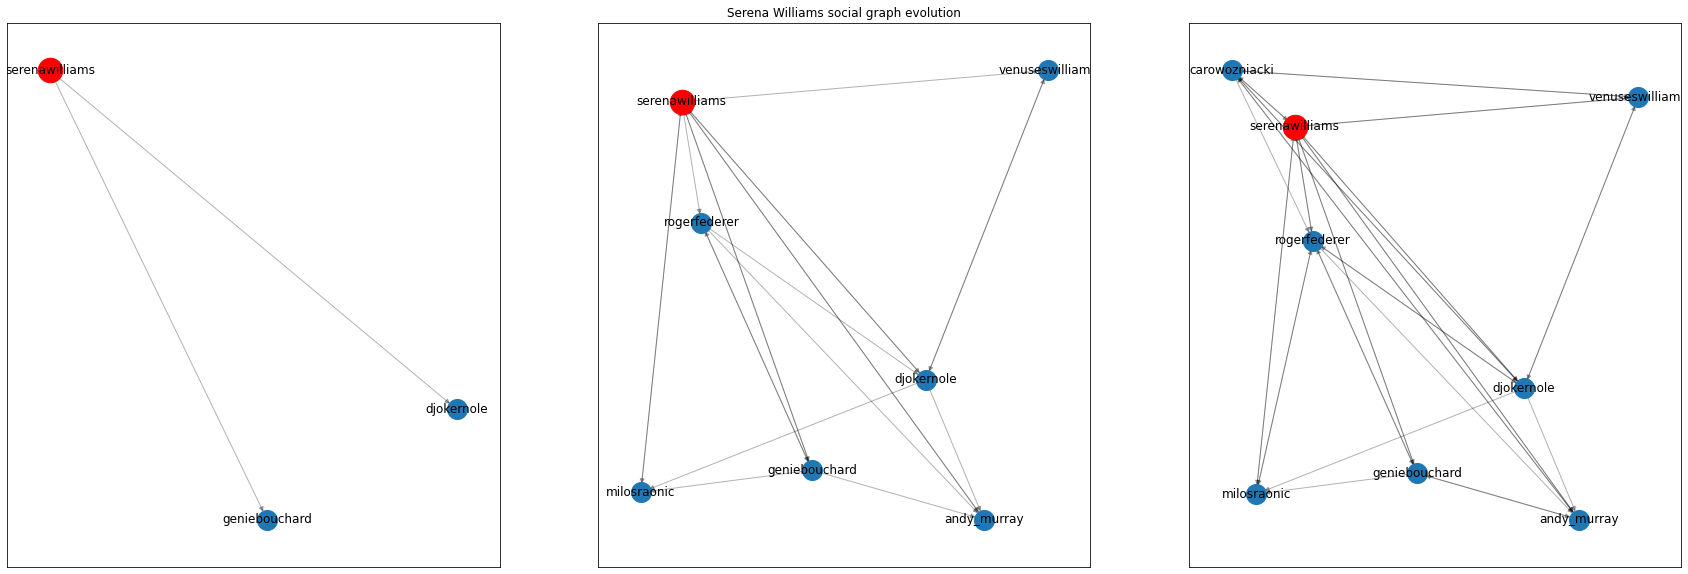

In [44]:
ego = 'serenawilliams'
pos = nx.spring_layout(snapshots[0], k=1)
fig, axs = plt.subplots(figsize=(30,10), ncols=3)
axs[1].set_title('Serena Williams social graph evolution', fontsize=12)
for i, g in enumerate(snapshots):
    eg = nx.ego_graph(g, ego)

    # draw network
    nx.draw_networkx_nodes(eg, pos=pos, node_size=400, ax=axs[i])
    nx.draw_networkx_edges(eg, pos=pos, alpha=0.3, ax=axs[i])
    
    # draw the ego in a different colour with larger node size
    nx.draw_networkx_nodes(eg, pos=pos, nodelist=[ego], node_size=600, 
                           node_color='red',  ax=axs[i])
    nx.draw_networkx_labels(eg, pos=pos, ax=axs[i])
plt.show()

In 2020, Williams followed only 2 accounts among our set, and was followed by none. In the following years, she extended her online social contacts to other tennis champins such as her sister Venus, Roger Federer, Djokovic, and more. Mirroring the trend show in the earlier plots, Williams visibly increased here connectiveness year after year. 

End of project